# Multi-Objective Deep Q Networks
### CS8803: Deep Reinforcement Learning

Team: Parisa Babolhavaeji, Ryan C Bowers, Bhavini Jeloka, Ghazal Mirzazadeh, Karthic Palaniappan

Multi-objective reinforcement learning (MORL) addresses the complex challenge of simultaneously optimizing multiple, often conflicting objectives, a scenario common across a broad spectrum of decision-making problems—from small-scale tasks such as travel planning to large-scale applications including defense procurement and wind farm control.
%
For a detailed exposition and illustrative examples, readers are referred to the survey paper: [A Practical Guide to Multi-Objective Reinforcement Learning and Planning](https://arxiv.org/abs/2103.09568).

Traditional reinforcement learning (RL) methods typically combine all objectives into a single scalar reward function.
%
While this scalarization simplifies optimization, it often compromises the explainability of the decision-making process and necessitates extensive tuning to identify a reward formulation that accurately reflects user preferences.
%
Moreover, such approaches fail to generalize in settings where user preferences are non-stationary.
%
To address these limitations, it is essential to represent each objective through its own reward component and introduce a utility function that explicitly captures user preferences and trade-offs among competing objectives.
%

Formally, the decision making problem is posed as a multi-objective Markov Decision Process (MOMDP).
%
An MOMDP comprises of a tuple $\langle S, A, T, \gamma, \mu, \mathbf{R} \rangle$, where: 
- $S$ is the state space
- $A$ is the action space
- $T \colon S \times A \times S \to \left[ 0, 1 \right]$ is a probabilistic transition function
- $\gamma \in [0, 1)$ is a discount factor
- $\mu \colon S \to [0,1]$ is a probability distribution over initial states 
- $\mathbf{R} \colon S \times A \times S \to \mathbb{R}^d$ is a \textit{vector-valued} reward function.


The vector-valued reward function $\mathbf{R}$ is what differentiates the MOMDP from the traditional MDP and each element in this vector corresponds to each of the considered objectives.
%

The overarching objective of reinforcement learning (RL)—whether in single-or multi-objective settings—has been to develop algorithms that are efficient, scalable, and generalizable, capable of computing optimal policies across a wide range of environments.
%
Building upon these foundational principles, our contributions are enlisted below:


1. \textbf{Efficiency improvement:} Enhance the performance of multi-objective deep reinforcement learning (MO-DRL) frameworks based on deep Q-networks by systematically analyzing the influence of hyperparameters and neural network architectures. To that extent we propose a multi-objective deep Q network (MO-DQN) for computing the optimal MORL policy.
2. \textbf{Scalability and generalization:} Extend the applicability of MO-DRL methods to more complex state–action spaces, such as those introduced in~\cite{felten_toolkit_2023}, inlcuding Deep Sea Treasure, Multi-Objective Mountain Car and a Resource-Gathering problem. Additionally, we compare MO-DQN with MONES and NES algorithms for the water management scenario introduced in the paper: [A Practical Guide to Multi-Objective Reinforcement Learning and Planning](https://arxiv.org/abs/2103.09568). 

This notebook demonstrates the scalability and generalization of MO-DQN across multiple representative environments. The algorithm effectively optimizes each objective and, since it learns a separate Q-function for every objective, it can support any linear utility function at deployment. Although we show only one utility function per environment, MO-DQN can be applied to any MORL setting and select actions that maximize a newly provided scalar utility.

### Imports
We first import all the necessary libraries and local classes. The list of packages can be found in the requirements.txt file.

In [1]:
import itertools
from datetime import datetime
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from typing import List, Tuple, Optional, Dict
from collections import deque
import pickle
import matplotlib.pyplot as plt

from learners.mo_dqn.mo_dqn_trainer import ReplayBuffer, MODQNTrainer
from learners.mo_dqn.mo_dqn_policy import MODQN
import gymnasium as gym
import mo_gymnasium as mo_gym

/Users/bhavinijeloka/miniforge3/envs/torch_env/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### Helper Codes
[Boilerplate] We construct a unified function to plot training curves and losses  in the following cell.

In [2]:
def smooth(values, weight=0.9):
    """
    Exponential moving average smoothing.
    weight close to 1 → more smoothing.
    """
    smoothed = []
    last = values[0]
    for v in values:
        last = last * weight + (1 - weight) * v
        smoothed.append(last)
    return smoothed


def plot_logs(log_file_path, smooth_factor=0.9):
    """
    Load logs (saved as .pkl) and produce:
    - A plot for each scalar log (episode_return, loss_per_update, avg_loss_per_episode)
    - Separate plots for each objective in mo_return
    - Optional smoothing (EMA)
    """

    with open(log_file_path, "rb") as f:
        logs = pickle.load(f)

    # ----------------------------
    # Plot scalar logs
    # ----------------------------
    for key in logs:
        if key == "Multi-Objective Returns":
            continue

        values = logs[key]

        if len(values) == 0:
            print(f"Skipping {key} (empty)")
            continue

        # Smooth
        smoothed = smooth(values, weight=smooth_factor)

        plt.figure(figsize=(6, 4))
        plt.plot(values, alpha=0.3)
        plt.plot(smoothed)
        plt.title(key)
        plt.xlabel("Episode / Update Index")
        plt.ylabel(key.replace("_", " "))
        plt.grid(True)
        plt.show()

    # ----------------------------
    # Plot multi-objective returns
    # ----------------------------
    mo_returns = logs["Multi-Objective Returns"]

    if len(mo_returns) > 0:
        mo_array = np.array(mo_returns)
        num_obj = mo_array.shape[1]

        for obj_idx in range(num_obj):
            raw = mo_array[:, obj_idx]
            smoothed = smooth(raw, weight=smooth_factor)

            plt.figure(figsize=(6, 4))
            plt.plot(raw, alpha=0.3)
            plt.plot(smoothed)
            plt.title(f"MO Return – Objective {obj_idx}")
            plt.xlabel("Episode")
            plt.ylabel(f"Return[{obj_idx}]")
            plt.grid(True)
            plt.show()

## Environment 1: Resource Gathering
[Resource Gathering](https://mo-gymnasium.farama.org/environments/resource-gathering/) is a grid-based environment where the agent's objective is to collect gold and/or diamond and reach home safely without being attacked by the enemy. The reward (MORL objective) is 3-dimensional:
- -1 if killed by an enemy, else 0
- +1 if returned home with gold, else 0
- +1 if returned home with diamond, else 0

### Learn the Policy

In [14]:
num_episodes = 10000
ep_len = 100
warmup_ep_len = 100

hyperparameters = { 
    'lr': 0.0005,
    'gamma': 0.99,
    'batch_size': 256,
    'utility_fn': [0.4, 0.3, 0.3],
    'layer_sizes': [128, 128],
    'epsilon_decay': 0.9997,
    'updates_per_episode': 50,
    'max_buffer_size':50000
}

num_actions, num_obs, num_objectives = 4, 4, 3
env = mo_gym.make("resource-gathering-v0") 

# Init classes
policy = MODQN(
    hyperparameters['utility_fn'],
    num_actions, num_obs, num_objectives,
    hyperparameters['layer_sizes']
)

replay_buffer = ReplayBuffer(max_size=hyperparameters['max_buffer_size'])

trainer = MODQNTrainer(
    policy,
    hyperparameters['lr'],
    hyperparameters['gamma'],
    hyperparameters['batch_size'],
    replay_buffer,
    env,
    epsilon_decay=hyperparameters['epsilon_decay'],
    updates_per_episode=hyperparameters['updates_per_episode']
)

trainer.train(num_episodes, ep_len=ep_len, warmup_ep_len=warmup_ep_len)

filepath = "training_logs_resource_gathering.pkl"
with open(filepath, "wb") as f:
    pickle.dump(trainer.logs, f)
print(f"Logs saved to {filepath}")

------------------------------------------------------------
Starting MODQN training for 10000 episodes...
------------------------------------------------------------
Filling buffer
Buffer filled
------------------------------------------------------------
Beginning main training loop
Episode 100/10000 | Return: 0.30 | Length: 35 | Loss: 0.0059 | Epsilon: 0.970 | 
  MO Return: [0. 1. 0.]
Episode 200/10000 | Return: 0.00 | Length: 1 | Loss: 0.0066 | Epsilon: 0.942 | 
  MO Return: [0. 0. 0.]
Episode 300/10000 | Return: 0.30 | Length: 47 | Loss: 0.0072 | Epsilon: 0.914 | 
  MO Return: [0. 1. 0.]
Episode 400/10000 | Return: 0.00 | Length: 100 | Loss: 0.0073 | Epsilon: 0.887 | 
  MO Return: [0. 0. 0.]
Episode 500/10000 | Return: 0.60 | Length: 100 | Loss: 0.0084 | Epsilon: 0.861 | 
  MO Return: [0. 1. 1.]
Episode 600/10000 | Return: 0.00 | Length: 2 | Loss: 0.0071 | Epsilon: 0.835 | 
  MO Return: [0. 0. 0.]
Episode 700/10000 | Return: 0.00 | Length: 2 | Loss: 0.0069 | Epsilon: 0.811 | 
  M

### Make Plots

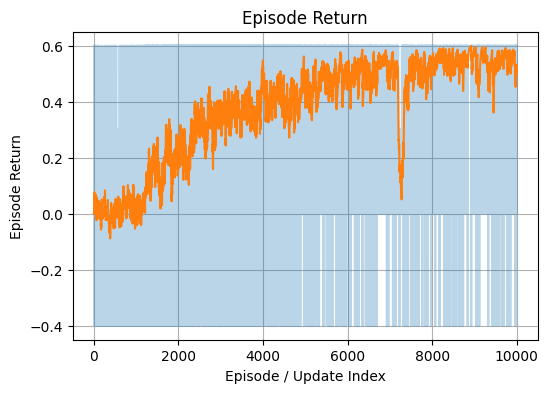

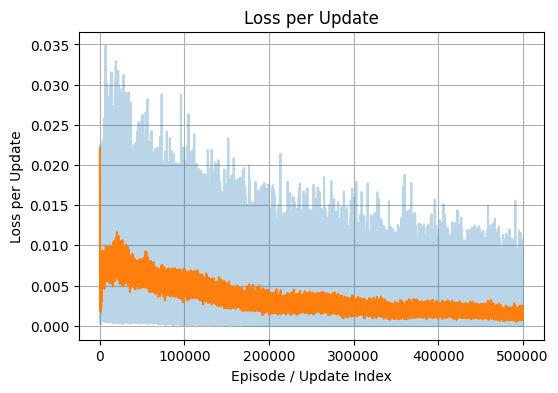

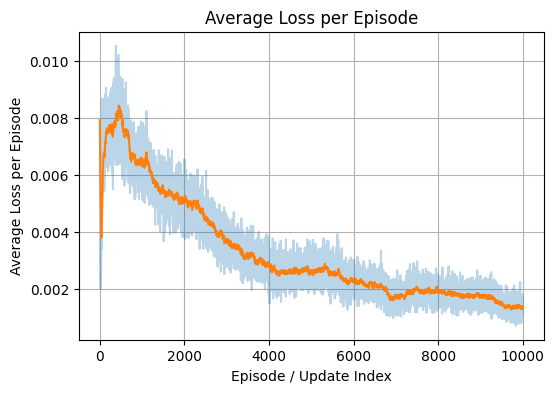

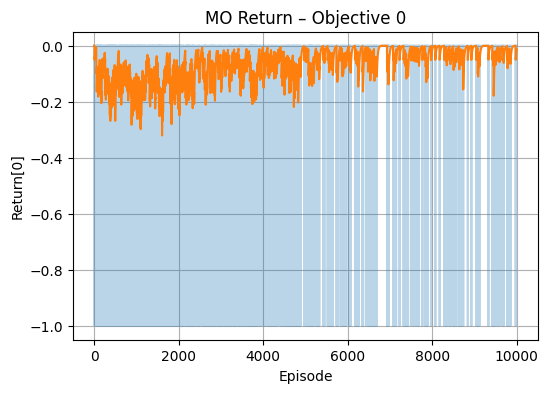

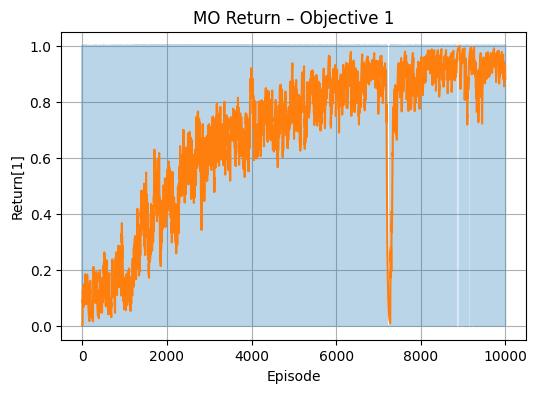

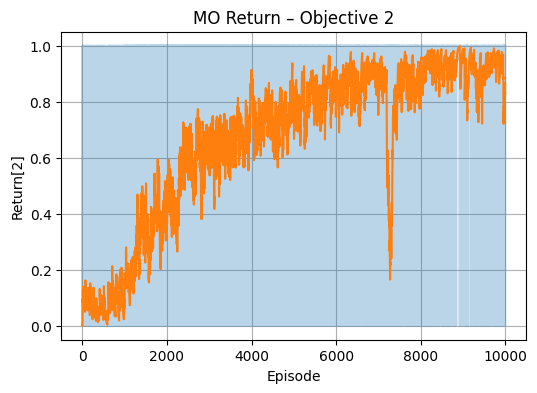

In [18]:
plot_logs(filepath, smooth_factor=0.95)

## Environment 2: Multi-Objective Mountain Car
[Multi-Objective Mountain Car](https://mo-gymnasium.farama.org/environments/mo-mountaincar/#) is an MORL extension of the standard single-objective mountain-car problem. Like the single-objective case, the goal of the agent (car) is to reach the top of the mountain. However, for the multi-objective case, the reward space is a 3D vector containing the time penalty, and penalties for reversing and going forward.
- time penalty: -1.0 for each time step
- reverse penalty: -1.0 for each time step the action is 0 (reverse)
- forward penalty: -1.0 for each time step the action is 2 (forward)

### Learn the Policy

In [20]:
num_episodes = 20000
ep_len = 100
warmup_ep_len = 200

hyperparameters = { 
   'lr': 0.0005,
    'gamma': 0.99,
    'batch_size': 256,
    'utility_fn': [0.4, 0.4, 0.2],
    'layer_sizes': [64, 64],
    'epsilon_decay': 0.9997, 
    'updates_per_episode': 50,
    'max_buffer_size':50000
}

num_actions, num_obs, num_objectives = 3, 2, 3
env = mo_gym.make("mo-mountaincar-v0") 

# Init classes
policy = MODQN(
    hyperparameters['utility_fn'],
    num_actions, num_obs, num_objectives,
    hyperparameters['layer_sizes']
)

replay_buffer = ReplayBuffer(max_size=hyperparameters['max_buffer_size'])

trainer = MODQNTrainer(
    policy,
    hyperparameters['lr'],
    hyperparameters['gamma'],
    hyperparameters['batch_size'],
    replay_buffer,
    env,
    epsilon_decay=hyperparameters['epsilon_decay'],
    updates_per_episode=hyperparameters['updates_per_episode']
)

trainer.train(num_episodes, ep_len=ep_len, warmup_ep_len=warmup_ep_len)

filepath = "training_logs_mo_mountain_car.pkl"
with open(filepath, "wb") as f:
    pickle.dump(trainer.logs, f)
print(f"Logs saved to {filepath}")

------------------------------------------------------------
Starting MODQN training for 20000 episodes...
------------------------------------------------------------
Filling buffer
Buffer filled
------------------------------------------------------------
Beginning main training loop
Episode 100/20000 | Return: -61.00 | Length: 100 | Loss: 0.5107 | Epsilon: 0.970 | 
  MO Return: [-100.  -40.  -25.]
Episode 200/20000 | Return: -59.40 | Length: 100 | Loss: 1.0318 | Epsilon: 0.942 | 
  MO Return: [-100.  -35.  -27.]
Episode 300/20000 | Return: -59.20 | Length: 100 | Loss: 0.9111 | Epsilon: 0.914 | 
  MO Return: [-100.  -37.  -22.]
Episode 400/20000 | Return: -58.00 | Length: 100 | Loss: 1.5239 | Epsilon: 0.887 | 
  MO Return: [-100.  -28.  -34.]
Episode 500/20000 | Return: -59.00 | Length: 100 | Loss: 0.0020 | Epsilon: 0.861 | 
  MO Return: [-100.  -31.  -33.]
Episode 600/20000 | Return: -56.40 | Length: 100 | Loss: 0.0006 | Epsilon: 0.835 | 
  MO Return: [-100.  -28.  -26.]
Episode 700

### Make Plots

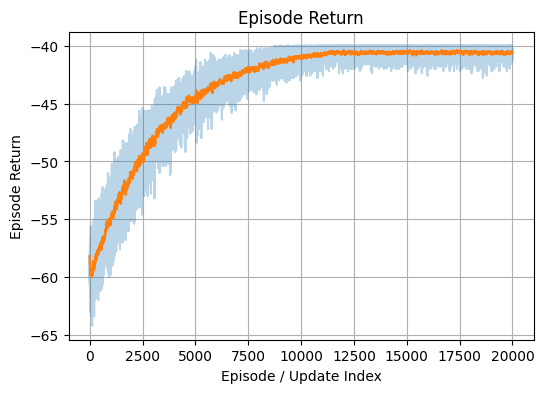

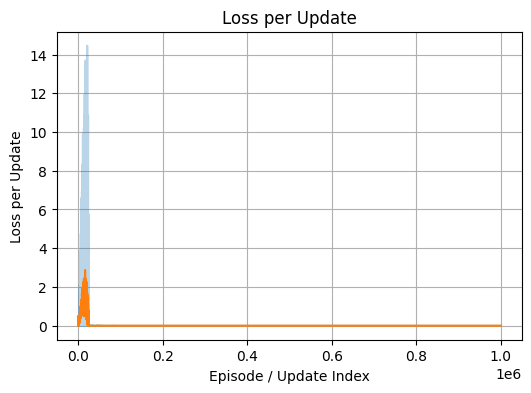

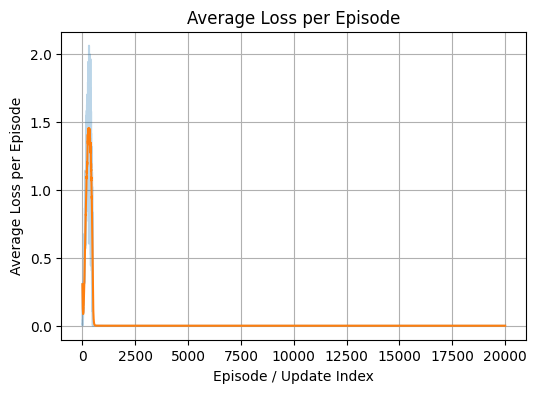

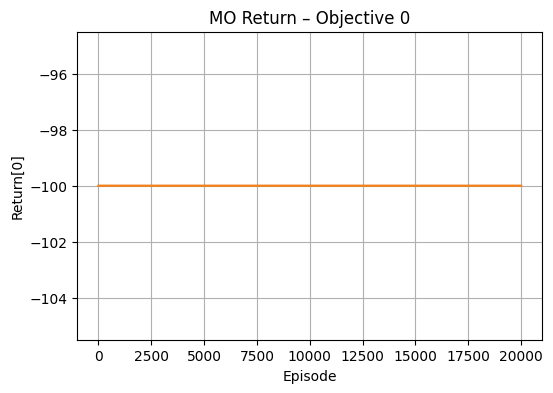

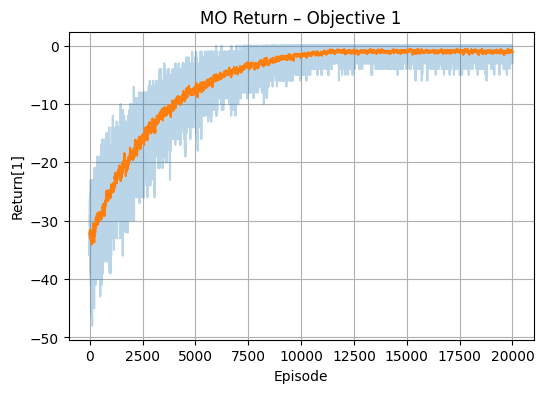

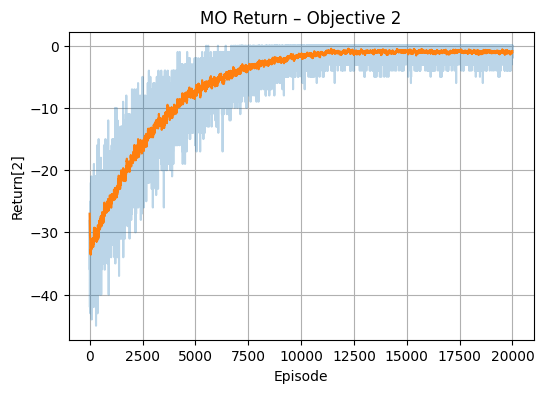

In [21]:
plot_logs(filepath, smooth_factor=0.95)

## Environment 3: Deep Sea Treasure
[Deep Sea Treasure](https://mo-gymnasium.farama.org/environments/deep-sea-treasure/#) one again, operates on a grid world. Here, the agent controls a submarine in a 2D grid world and seeks to optimize a 2D reward:
- time penalty: -1 at each time step
- treasure value: the value of the treasure at the current position

### Learn the Policy

In [22]:
num_episodes = 20000
ep_len = 100
warmup_ep_len = 200

hyperparameters = { 
   'lr': 0.0005,
    'gamma': 0.99,
    'batch_size': 256,
    'utility_fn': [0.5, 0.5],
    'layer_sizes': [128, 128],
    'epsilon_decay': 0.9997, 
    'updates_per_episode': 100,
    'max_buffer_size':50000
}

num_actions, num_obs, num_objectives = 4, 2, 2
env = mo_gym.make("deep-sea-treasure-v0") 

# Init classes
policy = MODQN(
    hyperparameters['utility_fn'],
    num_actions, num_obs, num_objectives,
    hyperparameters['layer_sizes']
)

replay_buffer = ReplayBuffer(max_size=hyperparameters['max_buffer_size'])

trainer = MODQNTrainer(
    policy,
    hyperparameters['lr'],
    hyperparameters['gamma'],
    hyperparameters['batch_size'],
    replay_buffer,
    env,
    epsilon_decay=hyperparameters['epsilon_decay'],
    updates_per_episode=hyperparameters['updates_per_episode']
)

trainer.train(num_episodes, ep_len=ep_len, warmup_ep_len=warmup_ep_len)

filepath = "training_logs_deep_sea_treasure.pkl"
with open(filepath, "wb") as f:
    pickle.dump(trainer.logs, f)
print(f"Logs saved to {filepath}")

------------------------------------------------------------
Starting MODQN training for 20000 episodes...
------------------------------------------------------------
Filling buffer
Buffer filled
------------------------------------------------------------
Beginning main training loop
Episode 100/20000 | Return: 1.10 | Length: 6 | Loss: 0.4891 | Epsilon: 0.970 | 
  MO Return: [ 8.2 -6. ]
Episode 200/20000 | Return: -0.15 | Length: 1 | Loss: 0.4143 | Epsilon: 0.942 | 
  MO Return: [ 0.7 -1. ]
Episode 300/20000 | Return: -14.85 | Length: 50 | Loss: 0.3848 | Epsilon: 0.914 | 
  MO Return: [ 20.3 -50. ]
Episode 400/20000 | Return: 3.25 | Length: 5 | Loss: 0.3586 | Epsilon: 0.887 | 
  MO Return: [11.5 -5. ]
Episode 500/20000 | Return: -11.65 | Length: 24 | Loss: 0.4190 | Epsilon: 0.861 | 
  MO Return: [  0.7 -24. ]
Episode 600/20000 | Return: -0.15 | Length: 1 | Loss: 0.3414 | Epsilon: 0.835 | 
  MO Return: [ 0.7 -1. ]
Episode 700/20000 | Return: -1.15 | Length: 3 | Loss: 0.3672 | Epsilon:

### Make Plots

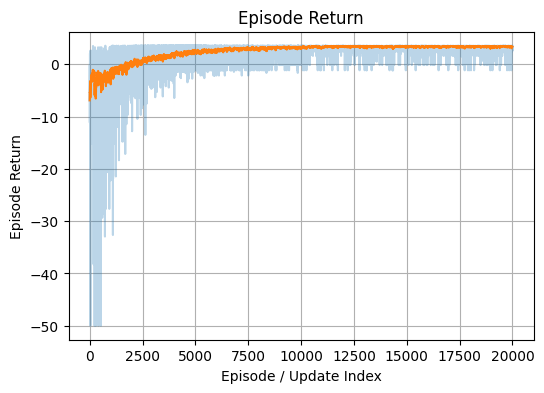

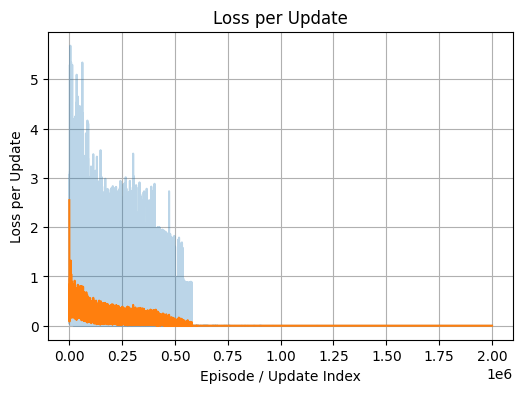

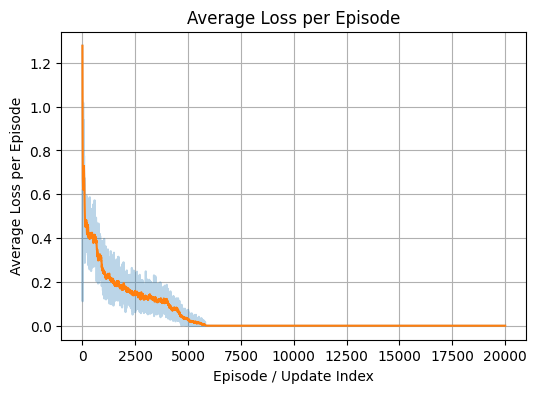

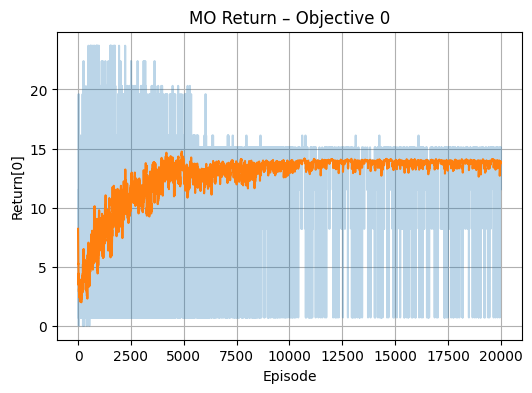

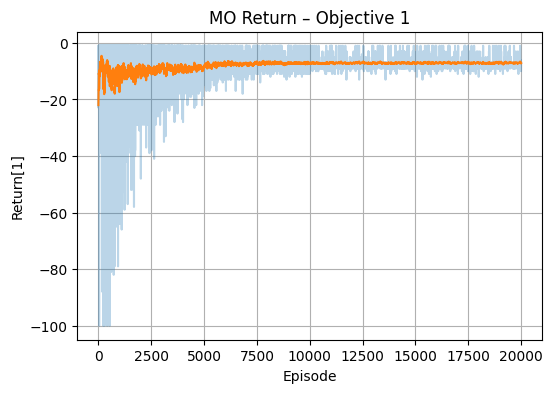

In [23]:
plot_logs(filepath, smooth_factor=0.95)